# Learning PyTorch
## Understanding Datasets and DataLoaders
Hey, I am Mukilan Krishnakumar and welcome to my repository for learning PyTorch. These notebooks are more so a learning tool for me rather than a teaching one.
I am learning PyTorch from variety of sources but primarily from PyTorch docs. As of learning (From 11th July, 2023), I am using PyTorch `2.0.1`. 

## 1. Loading Datasets
I am going to be using the `OxfordIIITPet` dataset. It has 37 categories (types of pets), it can be used for classification and segmentation. We are not building a model today, we will just explore few samples. 

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.OxfordIIITPet(
    root="data",
    split = "trainval",
    download=True,
    transform= ToTensor()
)

test_data = datasets.OxfordIIITPet(
    root="data",
    split = "test",
    download=True,
    transform= ToTensor()
)


## 2. Iterating and Visualizing a Dataset
We need to get the label mapping from categories to their IDs. We can easily do this through the `dataset.class_to_idx` method.

In [3]:
# Let us take training data
print(training_data.class_to_idx)

{'Abyssinian': 0, 'American Bulldog': 1, 'American Pit Bull Terrier': 2, 'Basset Hound': 3, 'Beagle': 4, 'Bengal': 5, 'Birman': 6, 'Bombay': 7, 'Boxer': 8, 'British Shorthair': 9, 'Chihuahua': 10, 'Egyptian Mau': 11, 'English Cocker Spaniel': 12, 'English Setter': 13, 'German Shorthaired': 14, 'Great Pyrenees': 15, 'Havanese': 16, 'Japanese Chin': 17, 'Keeshond': 18, 'Leonberger': 19, 'Maine Coon': 20, 'Miniature Pinscher': 21, 'Newfoundland': 22, 'Persian': 23, 'Pomeranian': 24, 'Pug': 25, 'Ragdoll': 26, 'Russian Blue': 27, 'Saint Bernard': 28, 'Samoyed': 29, 'Scottish Terrier': 30, 'Shiba Inu': 31, 'Siamese': 32, 'Sphynx': 33, 'Staffordshire Bull Terrier': 34, 'Wheaten Terrier': 35, 'Yorkshire Terrier': 36}


Notice that the output has interchanged "Keys" and "Values", let us fix it and store it in a variable called `label_map`

In [4]:
labels_map = dict((v,k) for k,v in training_data.class_to_idx.items())
print(labels_map)

{0: 'Abyssinian', 1: 'American Bulldog', 2: 'American Pit Bull Terrier', 3: 'Basset Hound', 4: 'Beagle', 5: 'Bengal', 6: 'Birman', 7: 'Bombay', 8: 'Boxer', 9: 'British Shorthair', 10: 'Chihuahua', 11: 'Egyptian Mau', 12: 'English Cocker Spaniel', 13: 'English Setter', 14: 'German Shorthaired', 15: 'Great Pyrenees', 16: 'Havanese', 17: 'Japanese Chin', 18: 'Keeshond', 19: 'Leonberger', 20: 'Maine Coon', 21: 'Miniature Pinscher', 22: 'Newfoundland', 23: 'Persian', 24: 'Pomeranian', 25: 'Pug', 26: 'Ragdoll', 27: 'Russian Blue', 28: 'Saint Bernard', 29: 'Samoyed', 30: 'Scottish Terrier', 31: 'Shiba Inu', 32: 'Siamese', 33: 'Sphynx', 34: 'Staffordshire Bull Terrier', 35: 'Wheaten Terrier', 36: 'Yorkshire Terrier'}


/var/folders/qp/h29sqr1j4qlg8r6r10m9q9xh0000gn/T/ipykernel_3888/3524628453.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343668887/work/aten/src/ATen/native/TensorShape.cpp:3575.)
  plt.imshow(img.T)


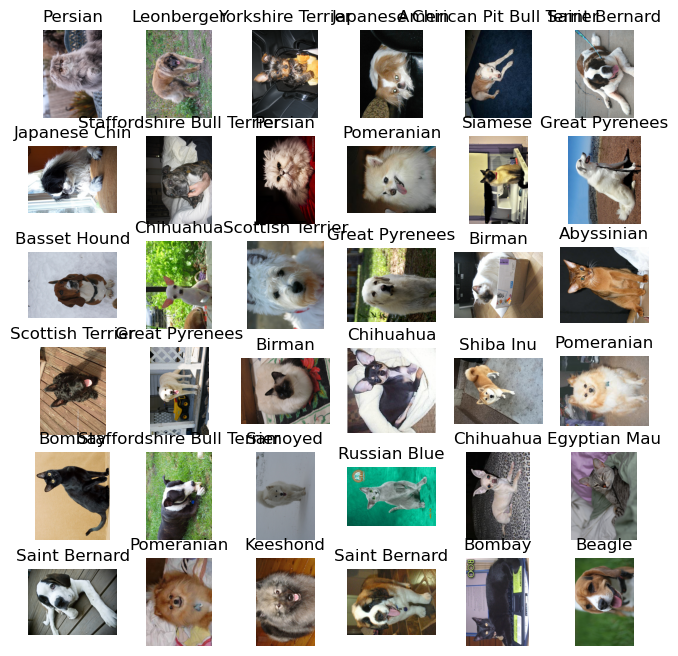

In [ ]:
figure = plt.figure(figsize=(8,8))
cols, rows = 6,6
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.T)
plt.show()

The problem with previous output happens to be the following error: `TypeError: Invalid shape (3, 225, 300) for image data`. We can solve this by `img.T` but that disorrients our image. THe best way to do this: `img.permute(1,2,0)`

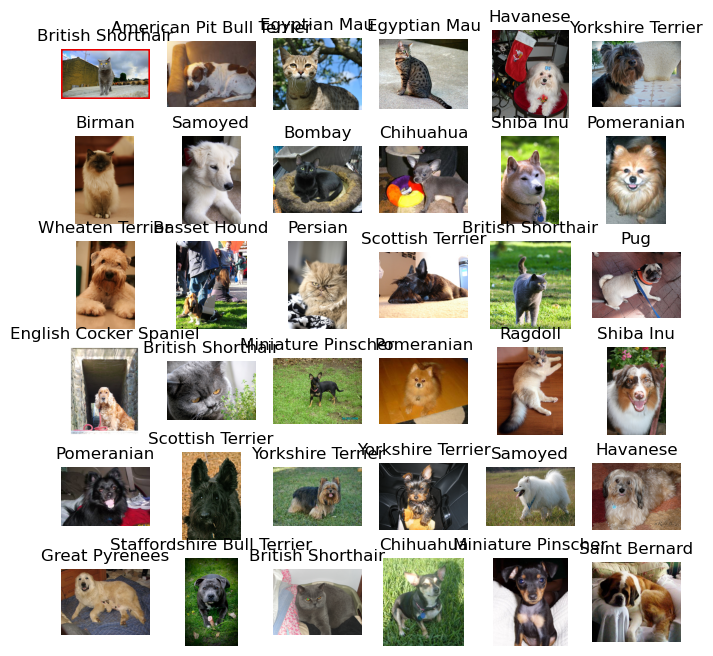

In [ ]:
figure = plt.figure(figsize=(8,8))
cols, rows = 6,6
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1,2,0))
plt.show()

## 3. Custom Dataset for our Data
Any Dataclass must have the following three methods:

    1. `__init__`
    2. `__len__`
    3. `__getitem__`

In [6]:
import os
import pandas as pd
from torchvision.io import read_image

In [8]:
# Testing out our data files - Annotations File to CSV
df = pd.read_csv(f"{training_data.root}/oxford-iiit-pet/annotations/trainval.txt", sep = " ", header = None)
df.head(5)

,0,1,2,3
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [11]:
# iloc is there to find the values at index (i) 
# Here the index is 200
df.iloc[200]

0    beagle_100
1             5
2             2
3             4
Name: 200, dtype: object

Now, we will be creating our Custom Dataset class. We will name it `PetImageDataset`. It has three methods, let us discuss them in brief.


1. `__init__` -> Runs when initialized, it gets initialized with annotations file, image directory and transforms.

2. `__len__` -> Returns the number of samples in dataset

3. `__getitem__` -> Given an index `idx`, it returns the image along with the label as tuple

A good question here would be: "Why use Dataset Classes in the first place? "

The main utility of `Dataset` is to retrieve our dataset's feature one sa

In [15]:
class PetImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform = None, target_transform = None):
        self.img_labels = pd.read_csv(annotations_file, sep = " ", header = None)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])+".jpg"
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            image = self.target_transform(label)
        return image, label
        

annotations_file = f"{training_data.root}/oxford-iiit-pet/annotations/trainval.txt"
img_dir = f"{training_data.root}/oxford-iiit-pet/images"
training_dataset = PetImageDataset(annotations_file= annotations_file, img_dir= img_dir)
        

In [16]:
training_dataset[99][0].shape

torch.Size([3, 500, 375])